In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.models.load_utils import get_model
from oodeel.methods.mls import MLS
from oodeel.methods.dknn import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt


from oodeel.eval.experiment import TwoDSExperiment
from oodeel.datasets.load import dataset_load
from oodeel.eval.experiment import SingleDSExperiment


2022-08-16 18:04:32.438053: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-16 18:04:32.445710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 18:04:32.445787: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Two datasets experiment

In [2]:
model = get_model("../saved_models/mnist_model")

2022-08-16 17:45:15.098131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-16 17:45:15.098188: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-16 17:45:15.098206: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (B20212474): /proc/driver/nvidia/version does not exist
2022-08-16 17:45:15.098466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### MLS

313/313 [==============================] - 2s 5ms/step
0.9947957849999999


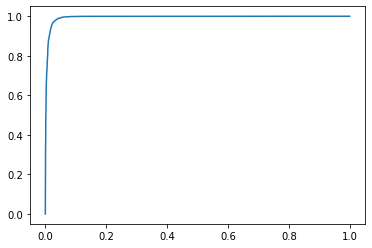

In [3]:

oodmodel = MLS
expe = TwoDSExperiment(id_dataset_name="mnist", ood_dataset_name="fashion_mnist")
(auroc), (tpc, fpc, tnc, fnc) = expe.run(model, oodmodel)

tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])

print(auroc)
plt.plot(fpr, tpr)
plt.show()


### DKNN

313/313 [==============================] - 2s 6ms/step
0.6690731950000001


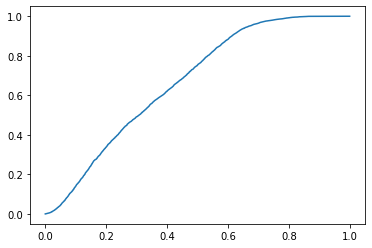

In [4]:
%autoreload 2

## This time need a dataset to fit KNN score
(x_train, y_train), (x_test, y_test) = dataset_load("mnist")

oodmodel = DKNN
expe = TwoDSExperiment(id_dataset_name="mnist", ood_dataset_name="fashion_mnist")
(auroc), (tpc, fpc, tnc, fnc) = expe.run(model, oodmodel, fit_dataset=x_train[:20000])

tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])

print(auroc)
plt.plot(fpr, tpr)
plt.show()

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

def training_mnist(x_train, y_train, config=None):
    input_shape = (28, 28, 1)
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(config["num_classes"], activation="softmax"),
        ]
    )

    batch_size = 128
    epochs = 5

    # compile and fit
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)    

    return model


## MLS

Epoch 1/5
212/212 [==============================] - 9s 40ms/step - loss: 0.2944 - accuracy: 0.9063 - val_loss: 0.0632 - val_accuracy: 0.9827
Epoch 2/5
212/212 [==============================] - 9s 43ms/step - loss: 0.0746 - accuracy: 0.9770 - val_loss: 0.0440 - val_accuracy: 0.9890
Epoch 3/5
212/212 [==============================] - 10s 46ms/step - loss: 0.0505 - accuracy: 0.9843 - val_loss: 0.0351 - val_accuracy: 0.9907
Epoch 4/5
212/212 [==============================] - 11s 50ms/step - loss: 0.0410 - accuracy: 0.9878 - val_loss: 0.0364 - val_accuracy: 0.9910
Epoch 5/5
155/155 [==============================] - 1s 8ms/step
0.9522135082934028


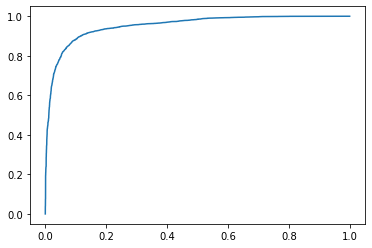

In [6]:
%autoreload 2

splits=[[1, 2, 3, 4, 5]]

#model = expe.model #for reinit
oodmodel = MLS 
expe = SingleDSExperiment(dataset_name="mnist", splits=splits)
#expe.model = model #for reinit
results = expe.run(oodmodel,
                   training_func=training_mnist, config={"num_classes": 5})

(auroc), (tpc, fpc, tnc, fnc) = results[str(splits[0])]

tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])

print(auroc)
plt.plot(fpr, tpr)
plt.show()

### DKNN

2022-08-16 17:55:02.406523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-16 17:55:02.406617: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-16 17:55:02.406646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (B20212474): /proc/driver/nvidia/version does not exist
2022-08-16 17:55:02.407111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
216/216 [==============================] - 10s 41ms/step - loss: 0.2355 - accuracy: 0.9295 - val_loss: 0.0396 - val_accuracy: 0.9886
Epoch 2/5
216/216 [==============================] - 9s 40ms/step - loss: 0.0576 - accuracy: 0.9817 - val_loss: 0.0286 - val_accuracy: 0.9931
Epoch 3/5
216/216 [==============================] - 8s 38ms/step - loss: 0.0427 - accuracy: 0.9867 - val_loss: 0.0271 - val_accuracy: 0.9938
Epoch 4/5
216/216 [==============================] - 9s 42ms/step - loss: 0.0332 - accuracy: 0.9899 - val_loss: 0.0263 - val_accuracy: 0.9931
Epoch 5/5
152/152 [==============================] - 1s 8ms/step
0.4706196336776915


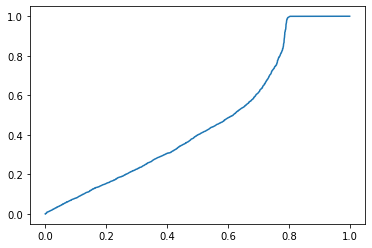

In [4]:
%autoreload 2

(x_train, y_train), (x_test, y_test) = dataset_load("mnist")

splits=[[0, 1, 2, 3, 4]]


oodmodel = DKNN 
expe = SingleDSExperiment(dataset_name="mnist", splits=splits)
#expe.model=model #for reinit
results = expe.run(oodmodel, 
                   training_func=training_mnist, config={"num_classes": 5},
                   fit_dataset=x_train[:20000])

(auroc), (tpc, fpc, tnc, fnc) = expe.results[str(splits[0])]
tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])

print(auroc)
plt.plot(fpr, tpr)
plt.show()